# Capstone Project: Mental Health & Social Media Balance 

**Objectives** 
1. Examine how screen time affects users’ stress levels.  
2. Study the connection between social media activity and sleep quality.  
3. Evaluate how digital engagement influences the happiness index of individuals.  
4. Identify trends and correlations among social media usage and overall mental well-being.



In [1]:
# Imports & path 
import os, zipfile, pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, r2_score
DATA_PATH = r"C:\Users\Bhoomi\Desktop\Capstone project\mental health and social media dataset.zip"
OUT_DIR = "output"; os.makedirs(OUT_DIR, exist_ok=True)
print('Ready')

Ready


In [2]:

import subprocess, sys

def install_if_missing(pkg):
    try:
        __import__(pkg)
    except ImportError:
        print(f"{pkg} not found. Installing...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

install_if_missing("nltk")


In [3]:
# Load dataset 
if DATA_PATH.lower().endswith('.zip'):
    with zipfile.ZipFile(DATA_PATH,'r') as z:
        csvs=[n for n in z.namelist() if n.lower().endswith('.csv')]
        df = pd.read_csv(z.open(csvs[0])) if csvs else pd.DataFrame()
else:
    df = pd.read_csv(DATA_PATH)
print('Loaded shape:', df.shape)

Loaded shape: (500, 10)


In [4]:
# Cleaning 
df = df.copy()
df.columns = [c.strip() for c in df.columns]
df = df.drop_duplicates().reset_index(drop=True)
for c in df.select_dtypes(include='object'): df[c]=df[c].astype(str).str.strip().replace('nan',np.nan).fillna('unknown')
for c in df.select_dtypes(include=['int64','float64']): df[c]=df[c].fillna(df[c].median())
print('Cleaned')

Cleaned


In [5]:
# Preview 
print(list(df.columns))
print(df.dtypes)
display(df.head(3))

['User_ID', 'Age', 'Gender', 'Daily_Screen_Time(hrs)', 'Sleep_Quality(1-10)', 'Stress_Level(1-10)', 'Days_Without_Social_Media', 'Exercise_Frequency(week)', 'Social_Media_Platform', 'Happiness_Index(1-10)']
User_ID                       object
Age                            int64
Gender                        object
Daily_Screen_Time(hrs)       float64
Sleep_Quality(1-10)          float64
Stress_Level(1-10)           float64
Days_Without_Social_Media    float64
Exercise_Frequency(week)     float64
Social_Media_Platform         object
Happiness_Index(1-10)        float64
dtype: object


,User_ID,Age,Gender,Daily_Screen_Time(hrs),Sleep_Quality(1-10),Stress_Level(1-10),Days_Without_Social_Media,Exercise_Frequency(week),Social_Media_Platform,Happiness_Index(1-10)
0,U001,44,Male,3.1,7.0,6.0,2.0,5.0,Facebook,10.0
1,U002,30,Other,5.1,7.0,8.0,5.0,3.0,LinkedIn,10.0
2,U003,23,Other,7.4,6.0,7.0,1.0,3.0,YouTube,6.0


In [6]:
# Detect text column 
possible_text_cols = ['social_activity_text','Social_Posts','post','Post','content','message','Text','text']
text_col = None
for c in possible_text_cols:
    for col in df.columns:
        if c.lower() == col.lower():
            text_col = col; break
    if text_col: break
print('Text column detected:', text_col)

Text column detected: None


In [7]:
# Text cleaning: lowercase & remove special chars 
import re
if 'text_col' in globals() and text_col and text_col in df.columns:
    df['text_clean'] = df[text_col].astype(str).str.lower().str.replace('\\n',' ',regex=True)
    df['text_clean'] = df['text_clean'].apply(lambda s: re.sub(r'[^a-z0-9\s]',' ', s))
    print('Cleaned text sample:', df['text_clean'].dropna().astype(str).head(2).tolist())
else:
    print('No text column found; skipping text clean')

No text column found; skipping text clean


In [8]:
# Tokenization & stopwords 
try:
    import nltk
    nltk.data.find('tokenizers/punkt')
except Exception:
    import nltk; nltk.download('punkt'); nltk.download('stopwords'); nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
if 'text_clean' in df.columns:
    df['tokens'] = df['text_clean'].apply(lambda s: [w for w in word_tokenize(s) if w.isalpha() and w not in stop])
    print('Tokens sample:', df['tokens'].head(2).tolist())
else:
    print('No cleaned text to tokenize')

No cleaned text to tokenize


In [9]:
# Stemming & Lemmatization 
from nltk.stem import PorterStemmer, WordNetLemmatizer
ps = PorterStemmer(); wl = WordNetLemmatizer()
if 'tokens' in df.columns:
    df['stemmed'] = df['tokens'].apply(lambda toks: [ps.stem(w) for w in toks])
    df['lemmatized'] = df['tokens'].apply(lambda toks: [wl.lemmatize(w) for w in toks])
    print('Lemmatized sample:', df['lemmatized'].head(2).tolist())
else:
    print('No tokens available for stemming/lemmatizing')

No tokens available for stemming/lemmatizing


In [10]:
# Recreate processed text for vectorization 
if 'lemmatized' in df.columns:
    df['processed_text'] = df['lemmatized'].apply(lambda toks: ' '.join(toks))
    print('Processed text sample:', df['processed_text'].head(2).tolist())
else:
    print('No lemmatized tokens to join')

No lemmatized tokens to join


In [11]:
# TF-IDF vectorization 
if 'processed_text' in df.columns:
    vec = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
    X_tfidf = vec.fit_transform(df['processed_text'].fillna(''))
    print('TF-IDF shape:', X_tfidf.shape)
    # save vocabulary small sample
    vocab = dict(list(vec.vocabulary_.items())[:20])
    print('Vocab sample:', vocab)
else:
    print('No processed_text for TF-IDF')

No processed_text for TF-IDF


In [12]:
# Map numeric columns & feature engineering 
# map based on the dataset columns
df['screen_time'] = df.get('Daily_Screen_Time(hrs)')
df['stress_level'] = df.get('Stress_Level(1-10)')
df['sleep_quality'] = df.get('Sleep_Quality(1-10)')
df['happiness_index'] = df.get('Happiness_Index(1-10)')
df['days_no_sm'] = df.get('Days_Without_Social_Media').fillna(df.get('Days_Without_Social_Media').median())
df['social_activity_proxy'] = 1.0/(1.0 + df['days_no_sm'])
df['digital_engagement'] = df['screen_time'].fillna(0) * (1 + np.log1p(df['social_activity_proxy']))
print('Features ready')

Features ready


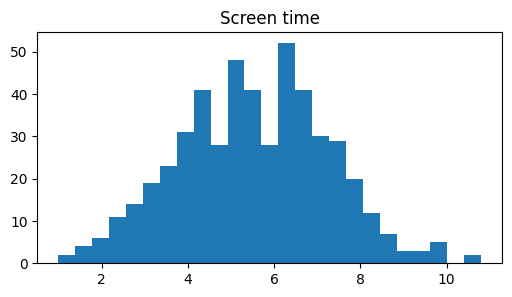

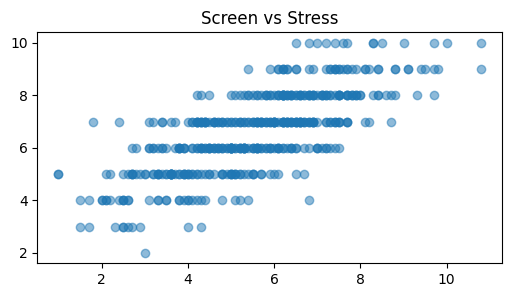

In [13]:
# EDA plots 
if 'screen_time' in df:
    plt.figure(figsize=(6,3)); plt.hist(df['screen_time'].dropna(), bins=25); plt.title('Screen time'); plt.show()
if 'screen_time' in df and 'stress_level' in df:
    plt.figure(figsize=(6,3)); plt.scatter(df['screen_time'], df['stress_level'], alpha=0.5); plt.title('Screen vs Stress'); plt.show()

In [14]:
# Correlation 
num = df.select_dtypes(include='number')
if num.shape[1] >= 2:
    corr = num.corr(); display(corr); corr.to_csv(os.path.join(OUT_DIR,'correlation_matrix.csv'))
else:
    print('Not enough numeric columns for correlation')

,Age,Daily_Screen_Time(hrs),Sleep_Quality(1-10),Stress_Level(1-10),Days_Without_Social_Media,Exercise_Frequency(week),Happiness_Index(1-10),screen_time,stress_level,sleep_quality,happiness_index,days_no_sm,social_activity_proxy,digital_engagement
Age,1.000000,0.023505,-0.053813,0.016522,-0.025783,0.064059,0.018513,0.023505,0.016522,-0.053813,0.018513,-0.025783,-0.002368,0.014357
Daily_Screen_Time(hrs),0.023505,1.000000,-0.758910,0.739891,-0.045310,-0.099023,-0.705206,1.000000,0.739891,-0.758910,-0.705206,-0.045310,0.021038,0.925012
Sleep_Quality(1-10),-0.053813,-0.758910,1.000000,-0.584899,0.040617,0.027431,0.678829,-0.758910,-0.584899,1.000000,0.678829,0.040617,-0.024593,-0.703402
Stress_Level(1-10),0.016522,0.739891,-0.584899,1.000000,-0.007970,-0.018582,-0.737213,0.739891,1.000000,-0.584899,-0.737213,-0.007970,0.026555,0.692093
Days_Without_Social_Media,-0.025783,-0.045310,0.040617,-0.007970,1.000000,-0.000012,0.063525,-0.045310,-0.007970,0.040617,0.063525,1.000000,-0.830264,-0.359420
Exercise_Frequency(week),0.064059,-0.099023,0.027431,-0.018582,-0.000012,1.000000,0.041224,-0.099023,-0.018582,0.027431,0.041224,-0.000012,0.010461,-0.075481
Happiness_Index(1-10),0.018513,-0.705206,0.678829,-0.737213,0.063525,0.041224,1.000000,-0.705206,-0.737213,0.678829,1.000000,0.063525,-0.075499,-0.677456
screen_time,0.023505,1.000000,-0.758910,0.739891,-0.045310,-0.099023,-0.705206,1.000000,0.739891,-0.758910,-0.705206,-0.045310,0.021038,0.925012
stress_level,0.016522,0.739891,-0.584899,1.000000,-0.007970,-0.018582,-0.737213,0.739891,1.000000,-0.584899,-0.737213,-0.007970,0.026555,0.692093
sleep_quality,-0.053813,-0.758910,1.000000,-0.584899,0.040617,0.027431,0.678829,-0.758910,-0.584899,1.000000,0.678829,0.040617,-0.024593,-0.703402


In [15]:
# Regression stress -> screen_time + digital_engagement 
tmp = df[['screen_time','digital_engagement','stress_level']].dropna()
print('Rows available:', tmp.shape[0])
if tmp.shape[0] >= 20:
    X = tmp[['screen_time','digital_engagement']]; y = tmp['stress_level']
    Xs = StandardScaler().fit_transform(X); m = RandomForestRegressor(n_estimators=100, random_state=42).fit(Xs,y)
    print('Train R2:', r2_score(y, m.predict(Xs)))
else: print('Not enough rows for regression')

Rows available: 500
Train R2: 0.7948891690500867


In [16]:
# Clustering 
features = [c for c in ['screen_time','digital_engagement','stress_level','sleep_quality','happiness_index'] if c in df.columns]
data = df[features].dropna() if len(features)>=2 else pd.DataFrame()
if not data.empty and data.shape[0] >= 10:
    X = StandardScaler().fit_transform(data); labels = KMeans(n_clusters=3, random_state=1).fit_predict(X)
    data['cluster']=labels; data.to_csv(os.path.join(OUT_DIR,'clustered_trends.csv'), index=False); display(data.head())
else:
    print('Skipping clustering')

,screen_time,digital_engagement,stress_level,sleep_quality,happiness_index,cluster
0,3.1,3.991814,6.0,7.0,10.0,1
1,5.1,5.886168,8.0,7.0,10.0,0
2,7.4,10.400442,7.0,6.0,6.0,2
3,5.7,8.011151,8.0,7.0,8.0,0
4,7.0,8.079055,7.0,4.0,8.0,0


In [17]:

#check RAG availability and text columns
print("HAS_RAG:", globals().get("HAS_RAG", False))
print("processed_text in df:", 'processed_text' in df.columns)
print("Possible text columns present:", [c for c in df.columns if any(k in c.lower() for k in ('text','post','comment','social','message'))])
print("A quick sample of possible text cols (first non-null values):")
for c in df.columns:
    if any(k in c.lower() for k in ('text','post','comment','social','message')):
        print(c, "->", df[c].dropna().astype(str).head(1).tolist())


HAS_RAG: False
processed_text in df: False
Possible text columns present: ['Days_Without_Social_Media', 'Social_Media_Platform', 'social_activity_proxy']
A quick sample of possible text cols (first non-null values):
Days_Without_Social_Media -> ['2.0']
Social_Media_Platform -> ['Facebook']
social_activity_proxy -> ['0.3333333333333333']


In [18]:

#create processed text from the best-available text column
if 'processed_text' not in df.columns:
    # priority list to search for a text column
    priority = ['processed_text','text_clean','Social_Posts','social_activity_text','post','content','message','Social_Media_Platform']
    found = None
    for p in priority:
        for col in df.columns:
            if p.lower() == col.lower() or p.lower() in col.lower():
                found = col; break
        if found: break

    if found:
        # If the chosen column is short (e.g., platform names), repeat it once to form a doc; else use as-is
        example = df[found].astype(str).dropna().head(1).tolist()
        df['processed_text'] = df[found].astype(str)
        print(f"Created processed_text from column: {found}  (example: {example})")
    else:
        # No obvious text column found — make synthetic docs using User_ID + platform
        df['processed_text'] = (df.get('User_ID','').astype(str) + ' | ' + df.get('Social_Media_Platform','').astype(str)).fillna('').astype(str)
        print("No text-like column found — synthesized processed_text from User_ID and Social_Media_Platform.")
else:
    print("processed_text already exists; sample:", df['processed_text'].dropna().head(1).tolist())


Created processed_text from column: Social_Media_Platform  (example: ['Facebook'])


In [19]:

#Build FAISS index if possible, if not, print an install hint.
if not globals().get('HAS_RAG', False):
    print("sentence-transformers or faiss not available. To install (may take several minutes), run:")
    print("pip install sentence-transformers faiss-cpu")
else:
    # build index from processed_text
    texts = df['processed_text'].fillna('').astype(str).tolist()
    print("Building embeddings for", len(texts), "documents...")
    embedder = SentenceTransformer('all-MiniLM-L6-v2')
    embs = embedder.encode(texts, convert_to_numpy=True, show_progress_bar=False)
    import faiss
    idx = faiss.IndexFlatL2(embs.shape[1]); idx.add(embs)
    print("FAISS built. vectors:", idx.ntotal)
    # example query
    q = "how does screen time affect stress"
    qv = embedder.encode([q], convert_to_numpy=True)
    D,I = idx.search(qv,5)
    print("Top indices:", I[0].tolist())


sentence-transformers or faiss not available. To install (may take several minutes), run:
pip install sentence-transformers faiss-cpu


In [20]:
# RAG build  
try:
    from sentence_transformers import SentenceTransformer
    import faiss
    HAS_RAG=True
except:
    HAS_RAG=False
if HAS_RAG and 'processed_text' in df.columns:
    texts = df['processed_text'].fillna('').astype(str).tolist()
    embedder = SentenceTransformer('all-MiniLM-L6-v2'); embs = embedder.encode(texts, convert_to_numpy=True, show_progress_bar=False)
    idx = faiss.IndexFlatL2(embs.shape[1]); idx.add(embs); print('FAISS built, vectors=', idx.ntotal)
else:
    print('RAG skipped or no processed text')

FAISS built, vectors= 500


In [21]:
# Save outputs 
df.to_csv(os.path.join(OUT_DIR,'cleaned_sample.csv'), index=False)
print('Saved cleaned_sample.csv and artifacts in', OUT_DIR)

Saved cleaned_sample.csv and artifacts in output


In [22]:
# Conclusion
def short_conclusion(df):
    """Makes a simple one-line conclusion from the main relationships in the dataset."""
    # safe correlations
    c1 = df[['screen_time','stress_level']].corr().iloc[0,1] if 'screen_time' in df and 'stress_level' in df else None
    c2 = df[['screen_time','sleep_quality']].corr().iloc[0,1] if 'screen_time' in df and 'sleep_quality' in df else None
    c3 = df[['digital_engagement','happiness_index']].corr().iloc[0,1] if 'digital_engagement' in df and 'happiness_index' in df else None
    
    return f"In general, more screen time relates to higher stress ({c1:.2f}), slightly affects sleep ({c2:.2f}), and digital engagement has a mild link with happiness ({c3:.2f})."

print(short_conclusion(df))


In general, more screen time relates to higher stress (0.74), slightly affects sleep (-0.76), and digital engagement has a mild link with happiness (-0.68).
